<a href="https://colab.research.google.com/github/kotharureshma/netflix-page/blob/main/age_n_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten,MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

**load dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []
image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)
for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])
  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
print(f'Number of age_labels: {len(age_labels)},Number of gender_labels: {len(gender_labels)},Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708,Number of gender_labels: 23708,Number of image_paths: 23708


In [ ]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths,age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/UTKFace/34_0_0_20170117134854584.jpg....,34,0
1,/content/UTKFace/24_1_1_20170113013149199.jpg....,24,1
2,/content/UTKFace/61_0_0_20170117192033956.jpg....,61,0
3,/content/UTKFace/29_0_1_20170117095006160.jpg....,29,0
4,/content/UTKFace/30_0_1_20170113152824163.jpg....,30,0


**exploratory data analysis**

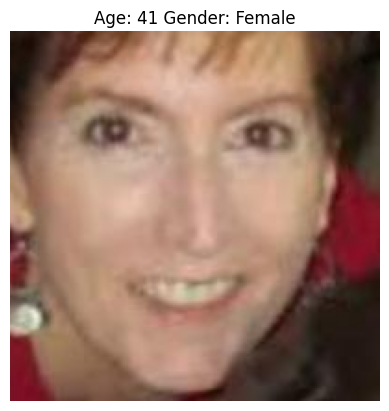

In [ ]:
from PIL import Image
rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

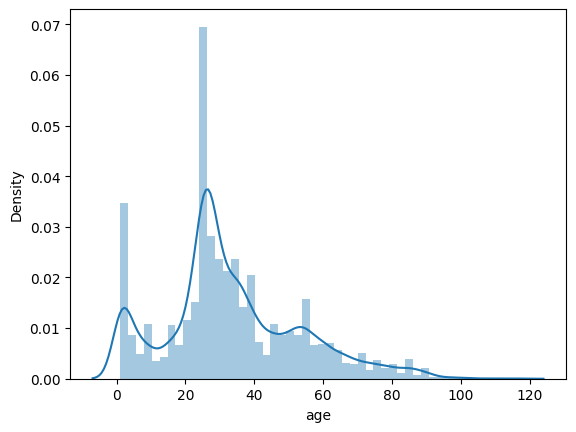

In [ ]:
 # Age distribution
 sns.distplot(df['age'])

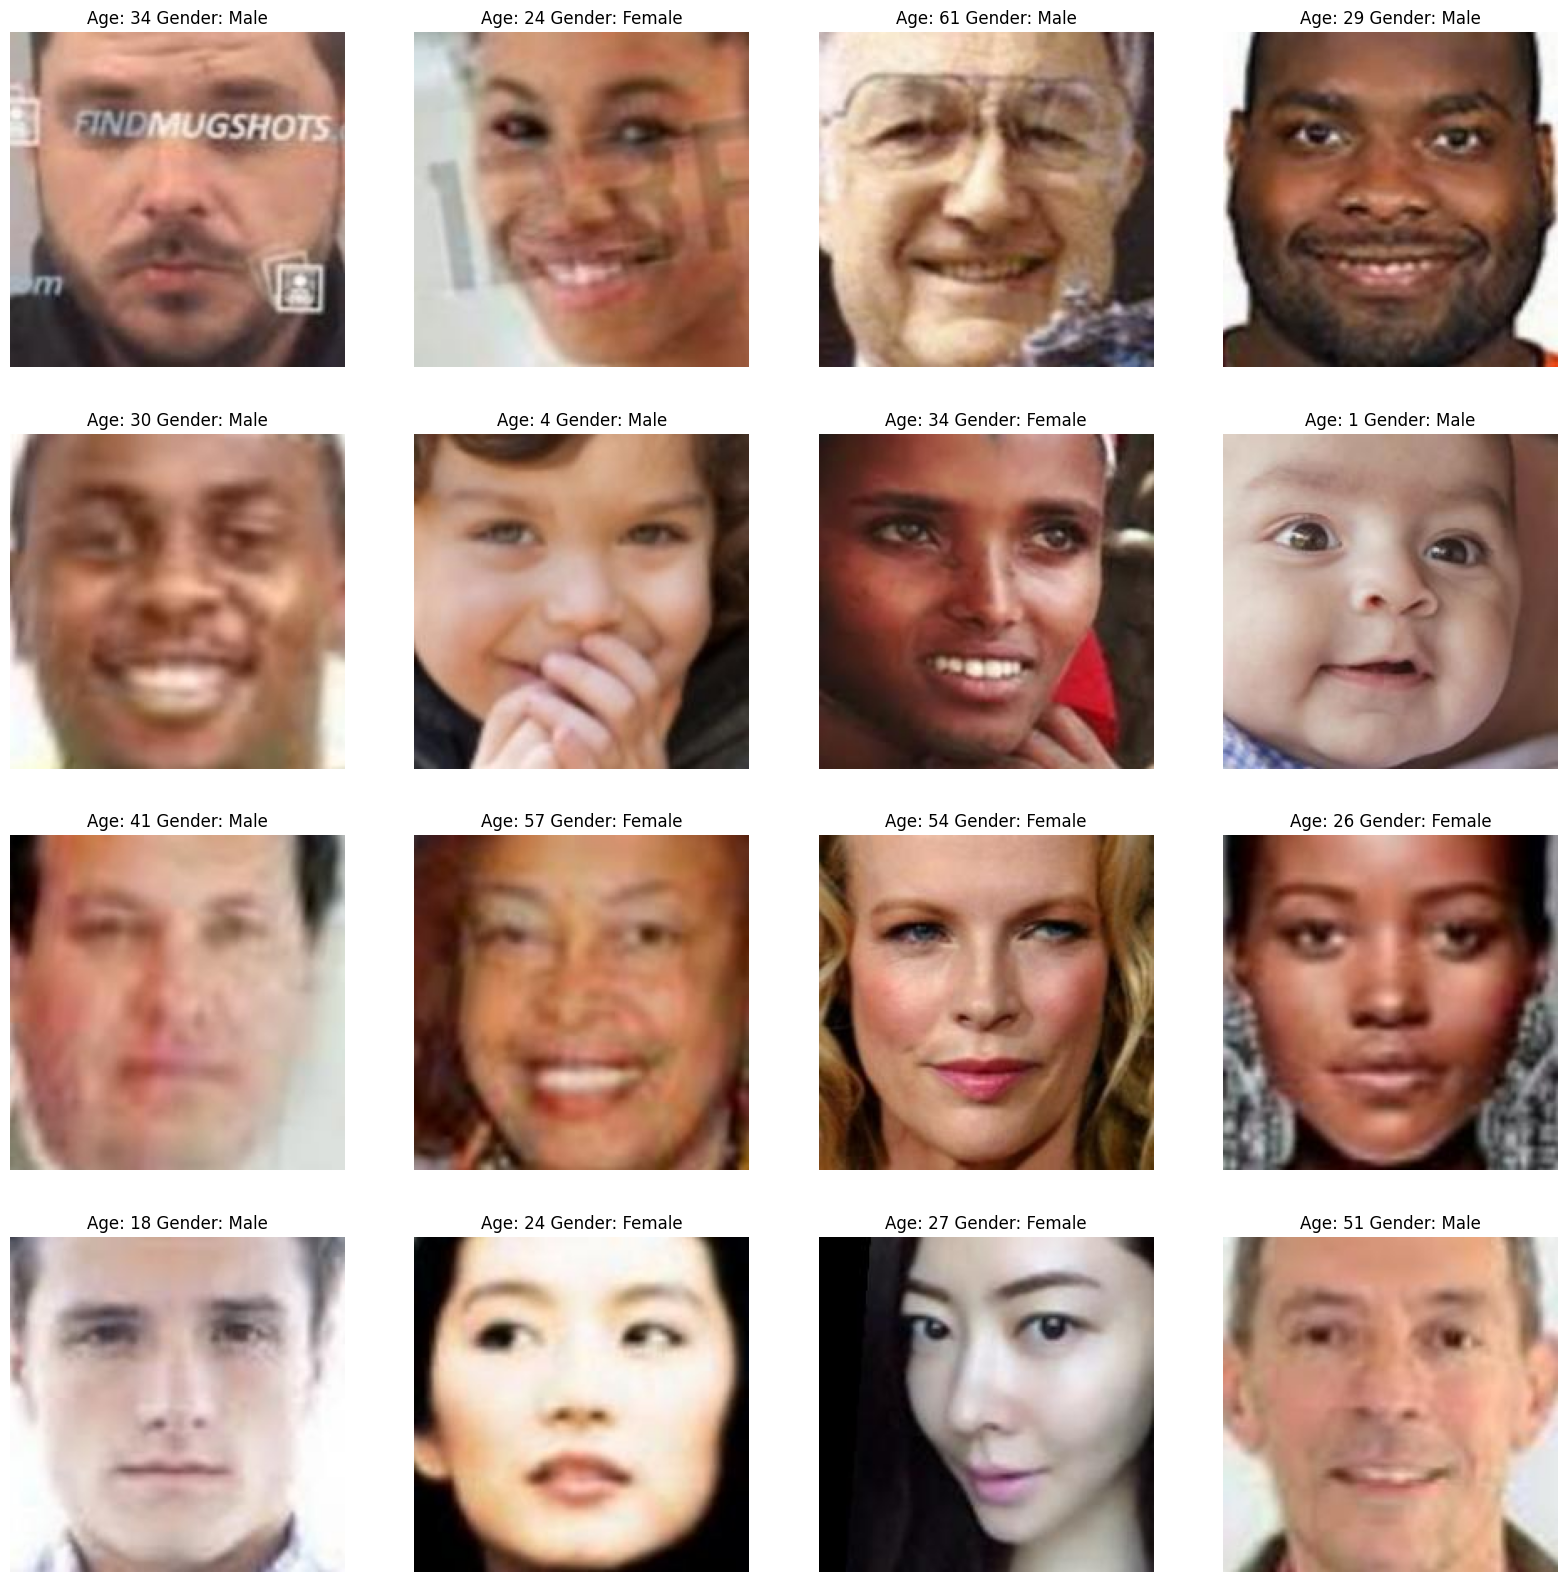

In [ ]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

**feature extraction**

In [ ]:
def extract_image_features(images):
    features = list()
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X / 255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

In [ ]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
flatten = Flatten()(max_4)
# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)


In [ ]:
model = Model(inputs=[inputs], outputs=[output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics=[['accuracy'], ['mae']])

In [ ]:
  history = model.fit(x=X, y=[y_gender, y_age],
                      batch_size=32, epochs=5,
                      validation_split=0.2)

Epoch 1/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 871s 1s/step - age_out_mae: 16.3037 - gender_out_accuracy: 0.5309 - loss: 17.0040 - val_age_out_mae: 11.6163 - val_gender_out_accuracy: 0.7278 - val_loss: 12.1696
Epoch 2/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 851s 1s/step - age_out_mae: 11.2921 - gender_out_accuracy: 0.7646 - loss: 11.7821 - val_age_out_mae: 10.4345 - val_gender_out_accuracy: 0.8081 - val_loss: 10.8456
Epoch 3/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 864s 1s/step - age_out_mae: 9.7112 - gender_out_accuracy: 0.8045 - loss: 10.1329 - val_age_out_mae: 8.3333 - val_gender_out_accuracy: 0.8349 - val_loss: 8.6921
Epoch 4/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 852s 1s/step - age_out_mae: 8.5163 - gender_out_accuracy: 0.8288 - loss: 8.8876 - val_age_out_mae: 7.7524 - val_gender_out_accuracy: 0.8452 - val_loss: 8.0855
Epoch 5/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - age_out_mae: 7.8654 - gender_out_accuracy: 0.8481 - loss: 8.1970 - val_age_out_mae: 7.2764 - val_gender_out_accuracy: 0.8496 - val_loss: 7.6108


**plot results**

<Figure size 640x480 with 0 Axes>

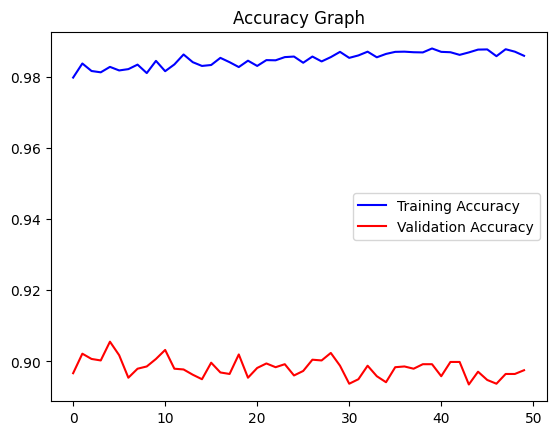

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot results for gender
history_dict=history.history
acc = history_dict['gender_out_accuracy']
val_acc = history_dict['val_gender_out_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

**predicting test data**

In [ ]:
def get_image_features(image):
  img = load_img(image,color_mode='grayscale')
  img = img.resize((128, 128), Image.Resampling.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


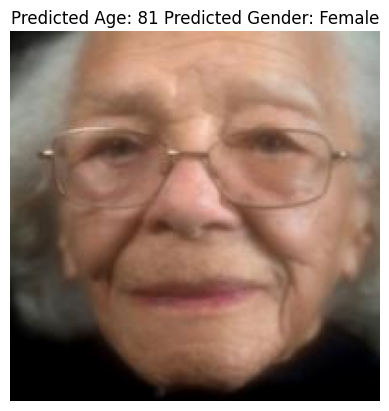

In [ ]:
img_to_test = '/content/utkface_aligned_cropped/UTKFace/100_1_0_20170112215032192.jpg.chip.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])
plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))